In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

words = open('names.txt').read().splitlines()
# build vocab of characters and mappings to / from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)

In [2]:
import random
# build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))  
n2 = int(0.9 * len(words))
Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

## structuring code so it look more like pytorch

In [3]:
g = torch.Generator().manual_seed(42)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in**0.5) 
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class LeakyRelu:
    def __call__(self, x):
        self.out = torch.nn.functional.leaky_relu(x)
        return self.out
    
    def parameters(self):
        return []
    

class Adam:
    def __init__(self, params, lr=0.001, beta1 = 0.9, beta2 = 0.999, eps = 1e-08):
        self.lr = lr
        self.params = params
        self.beta1 = torch.tensor(beta1)
        self.beta2 = torch.tensor(beta2)
        self.eps = eps
        self.m_d = {id(p) : torch.zeros_like(p) for p in params}
        self.v_d = {id(p) : torch.zeros_like(p) for p in params}
        self.t = 1

    def step(self):
        for param in self.params:
            grad = param.grad
            m = self.m_d[id(param)]
            v = self.v_d[id(param)]

            next_m = (torch.multiply(self.beta1, m) + torch.multiply(1.0 - self.beta1, grad))
            next_v = (torch.multiply(self.beta2, v) + torch.multiply(1.0 - self.beta2, torch.pow(grad, 2)))

            m_hat = torch.divide(next_m, (1 - torch.pow(self.beta1, self.t)))
            v_hat = torch.divide(next_v, (1 - torch.pow(self.beta2, self.t)))

            param.data = param.data - torch.divide(torch.multiply(self.lr, m_hat), (torch.sqrt(v_hat) + self.eps))

            self.m_d[id(param)] = next_m
            self.v_d[id(param)] = next_v
        self.t += 1

In [4]:
n_embd = 10
n_hidden = 100
block_size = 3
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)

# for training: 
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), LeakyRelu(),
    Linear(n_hidden, n_hidden),  BatchNorm1d(n_hidden), LeakyRelu(),
    Linear(n_hidden, n_hidden),  BatchNorm1d(n_hidden), LeakyRelu(),
    Linear(n_hidden, n_hidden),  BatchNorm1d(n_hidden), LeakyRelu(),
    Linear(n_hidden, n_hidden),  BatchNorm1d(n_hidden), LeakyRelu(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= np.sqrt(2 / (1 + (0.01)**2))

parameters = [C] + [p for layer in layers for p in layer.parameters()]
parameters
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad_()

48229


In [25]:
max_steps = 20000
batch_size = 64
lossi = []
ud = []
lr = 0.001
# optimizer = torch.optim.Adam([p['param'] for p in parameters], lr=0.001)  
optimizer = Adam([p for p in parameters], lr=lr)

for i in range(max_steps):
    ix = torch.randint(0, Xtrain.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtrain[ix], Ytrain[ix]

    C_params = C
    emb = C_params[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # adam optimizer:
    optimizer.step()

    # stochastic gradient descent:
    # lr = 0.1 if i < 100000 else 0.01
    # for p in parameters:
    #     p.data -= lr * p.grad

    if i % 100 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

      0/  20000: 1.9091
    100/  20000: 1.8598
    200/  20000: 2.1300
    300/  20000: 2.0442
    400/  20000: 2.1758
    500/  20000: 2.2209
    600/  20000: 2.1688
    700/  20000: 1.8786
    800/  20000: 2.3160
    900/  20000: 2.0771


layer 2 ( LeakyRelu): mean +0.38, std 0.54, saturated: 30.20%
layer 5 ( LeakyRelu): mean +0.35, std 0.57, saturated: 34.53%
layer 8 ( LeakyRelu): mean +0.32, std 0.58, saturated: 43.11%
layer 11 ( LeakyRelu): mean +0.33, std 0.57, saturated: 42.62%
layer 14 ( LeakyRelu): mean +0.37, std 0.61, saturated: 42.50%


Text(0.5, 1.0, 'activation distribution')

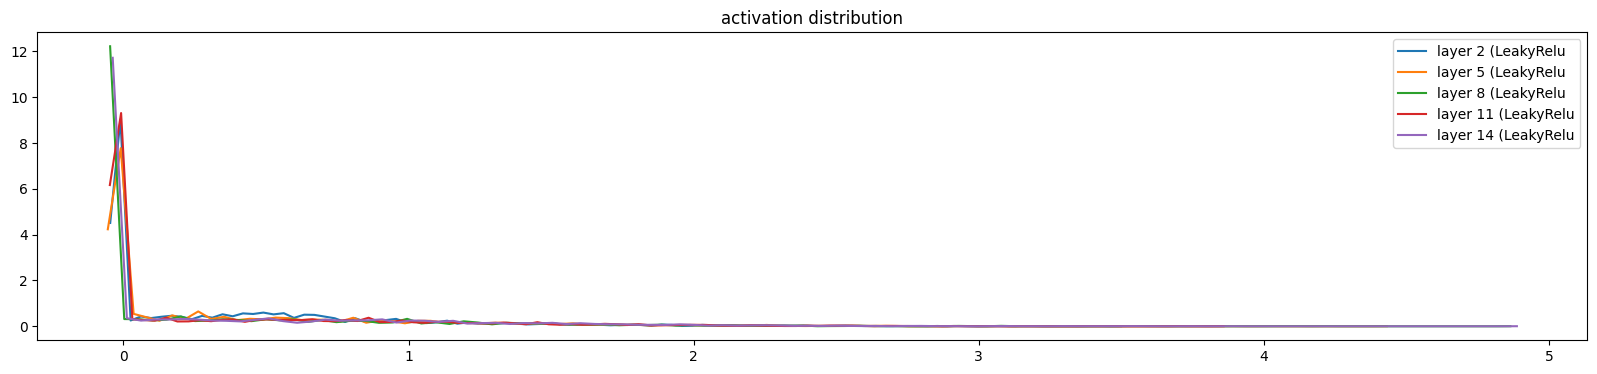

In [26]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, LeakyRelu):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() < 0.01).float().mean() * 100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

layer 2 ( LeakyRelu): mean +0.000026, std 1.977435e-03
layer 5 ( LeakyRelu): mean -0.000039, std 1.772439e-03
layer 8 ( LeakyRelu): mean -0.000009, std 1.700075e-03
layer 11 ( LeakyRelu): mean +0.000051, std 1.673750e-03
layer 14 ( LeakyRelu): mean -0.000027, std 1.795349e-03


Text(0.5, 1.0, 'gradient distribution')

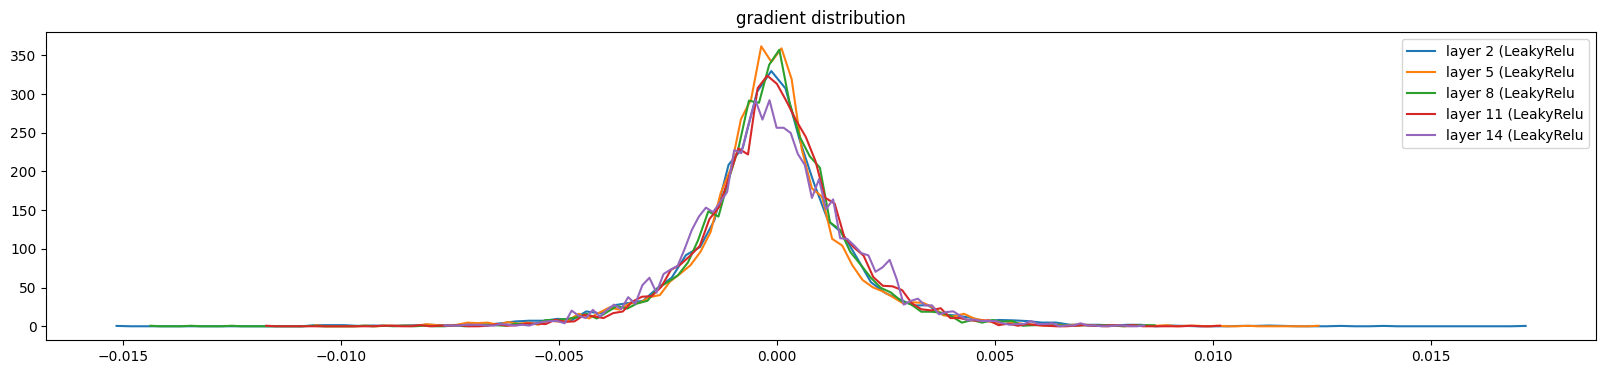

In [27]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, LeakyRelu):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (33, 10) | mean -0.000038 | std 8.009198e-03 | grad:data ratio 7.730498e-03
weight  (30, 100) | mean +0.000007 | std 7.691219e-03 | grad:data ratio 2.536588e-02
weight (100, 100) | mean -0.000706 | std 4.818811e-03 | grad:data ratio 2.324086e-02
weight (100, 100) | mean -0.000432 | std 4.475267e-03 | grad:data ratio 2.155775e-02
weight (100, 100) | mean -0.000086 | std 4.271511e-03 | grad:data ratio 2.057640e-02
weight (100, 100) | mean -0.000377 | std 3.810826e-03 | grad:data ratio 1.827005e-02
weight  (100, 33) | mean -0.000069 | std 8.479322e-03 | grad:data ratio 3.952839e-02


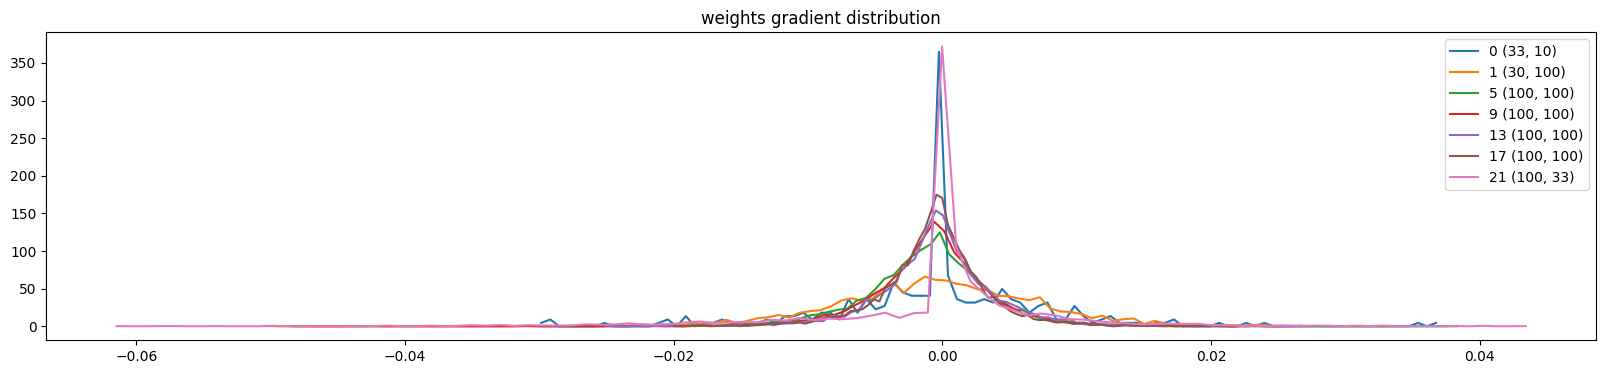

In [28]:

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title('weights gradient distribution');

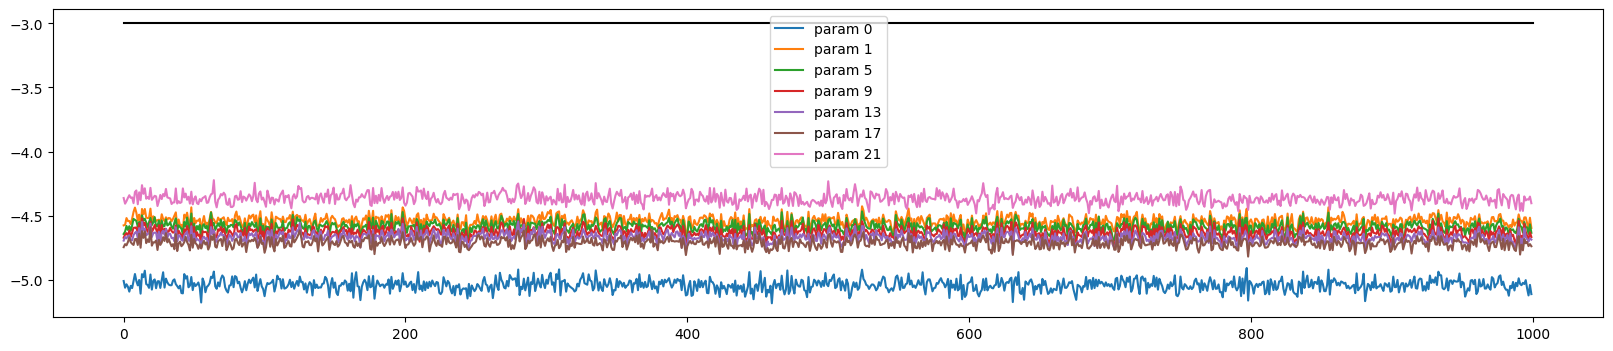

In [29]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [20]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtrain, Ytrain),
    'val': (Xdev, Ydev),
    'test': (Xtest, Ytest),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.0942463874816895
val 2.1355626583099365


In [24]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out[:-1])) # decode and print the generated word

mon
ammyah
seel
ndheyah
renya
jendraig
azeer
melin
shivonna
keisean
naraelyzion
kamin
shubergiairiel
kindreelynn
novana
ubreyven
kylene
ehsyn
ajayson
daihan
